# Stanford Ribonanza RNA Folding Introduction
For people (like myself)
who don't have a biology background, understanding what this competition is really asking you to do can be a little challenging, especially since the train, test and sample submission datasets look so different. This notebook aims to help you get started with the competition, not by going through every single folder or explaining some of the details behind knot theory (for which you can check out some other excellent notebooks), but to share just what you might find helpful to dive in for yourself. If you think I left out something or would like to expand on this work, please feel free to do so. Lastly, if you find this notebook helpful, please leave an upvote 👍 so that this work can reach a wider audience.

### Part 1: Imports and Setup
Most of these imports are quite standard (e.g., `pandas`, `tqdm`, `matplotlib`), and you have likely used these yourselves. Since the dataset sizes in this competition are fairly large, it might also be worth considering `polars` (a fast, Rust-based alternative to `pandas`), but since many here are more familiar with `pandas`, that's what I'll use here.

In [ ]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

This cell contains some basic processing so that you can run this notebook on Kaggle or locally on your machine (originally found this in Jeremy Howard's work - see https://www.kaggle.com/code/jhoward/iterate-like-a-grandmaster).

For this notebook, I'll be making use of the competition data provided by Kaggle, as well as [this dataset](https://www.kaggle.com/datasets/iafoss/stanford-ribonanza-rna-folding-converted/) by @iafoss that holds the train and test datasets converted into the Parquet format, which allows for dataset sizes to be smaller, and can speed up loading times.

In [ ]:
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    # Get the data path from within Kaggle
    default_path = Path('/kaggle/input/stanford-ribonanza-rna-folding')    # Data from Kaggle (CSV)
    path = Path('/kaggle/input/stanford-ribonanza-rna-folding-converted')  # Data by @iafoss (Parquet)
else:
    # Get the data path from our local machine
    path = Path('..data/')

### Part 2: Loading in the data

In [ ]:
train = pd.read_parquet(path/'train_data.parquet')
print(train.shape)
train.head()

In [ ]:
test = pd.read_parquet(path/'test_sequences.parquet')
print(test.shape)
test.head()

In [ ]:
ss = pd.read_csv(default_path / 'sample_submission.csv')
print(ss.shape)
ss.head()

#### For those unfamiliar with DNA and RNA:

###### Disclaimer: Over-simplification

In short, DNA and RNA can be thought of as a long sequence of the following bases (which in this dataset are represented by letters): A, C, G, T and U.
Each letter maps to a specific *nitrogenous base* (which, for the purposes of this competition, is just a molecule with some properties that make it bond in certain ways to create DNA and RNA):
* A -> Adenine
* C -> Cytosine
* G -> Guanine
* T -> Thymine (DNA only)
* U -> Uracil (RNA only)

and groups of three bases are known as *codons*, which can code for specific amino acids. For instance, the codon AUG (adenine, uracil and thymine codes for the amino acid methionine). These amino acids come together to form the proteins that do all the "work" our body needs. There are hundreds of known amino acids, but only about 20 make up the proteins we find in the human body. 

Let's take a look at an example sequence from our train dataset:

In [ ]:
train.sequence[0]

Since this competition deals with RNA, we should only see A, C, G and U, and never T. Let's confirm that:

In [ ]:
set(''.join(list(train.sequence)))

In [ ]:
test.sequence.apply(len).min()

And the same should be true for the test dataset:

In [ ]:
set(''.join(list(test.sequence)))

#### Shapes of DNA and RNA

So the primary objective of this competition is to predict RNA folding, but first we need to understand the differences in the shapes of these molecules.

##### DNA
DNA is a double-stranded molecule - simply, this means that it consists of two long sequences paired together according to the following rules:
1. A (adenine) always pairs with T (thymine), and vice versa
2. C (cytosine) always pairs with G (guanine), and vice versa
(NOTE: There are special cases where G and U can pair as well, but for simplicity's sake, we ignore this possibility).

So for instance, the following sequence (or strand): ATCGTAAC, is paired with the following complementary sequence (or strand): TAGCATTG.

In DNA, these two strands come together to form a tightly woven, double helix structure and this gives DNA many of its interesting properties.
This is illustrated below:

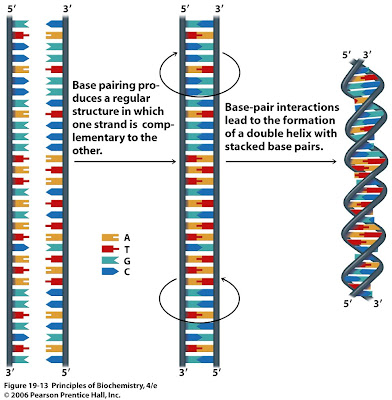



##### RNA
RNA, however, is single-stranded (i.e., it has only one sequence, instead of two paired sequences). This means that it is free to take on a huge number of more interesting shapes than DNA, locked in its double helix, can - it does this by *folding in on itself*, pairing its own bases together (according to the same rules above, except now bases can be unpaired as well. ). 

For instance, consider the following sequence: AAGAGCC.
We know that the a G must pair with a C, and an A must pair with a U (in RNA). However, this sequence doesn't have any U bases - therefore, the As must be unpaired in the final structure. The Gs and Cs, unfortunately, are more ambiguous. The first G could pair with the last C, the second to last C, or with nothing at all. The second G has the same three possibilities, for a total of 3 + 3 = 6 possibilities for the structure of a simple, 7-base long sequence - in our training set, examples range from 115 to 206 bases long, and in the test set, sequences can be as long as 457 bases. Clearly, listing out possibilities by hand isn't going to get us very far.

This is really the essence of the RNA folding problem - **given the raw sequence of letters of an RNA strand, can we build a model to predict the shape it will take?**

Example of RNA molecule, once it has folded: https://www.google.com/imgres?imgurl=https%3A%2F%2Fi.ytimg.com%2Fvi%2F2XTi9LG9NnU%2Fmaxresdefault.jpg&tbnid=tuc_B4XDsom_qM&vet=12ahUKEwifkdvHjsCCAxUqElkFHW3hA6sQMygQegQIARBw..i&imgrefurl=https%3A%2F%2Fnews.northwestern.edu%2Fstories%2F2021%2F01%2Fnew-videos-show-rna-as-its-never-been-seen%2F&docid=lkNT0YHFp6vi_M&w=1280&h=720&q=rna%20folded%20structure&ved=2ahUKEwifkdvHjsCCAxUqElkFHW3hA6sQMygQegQIARBw

### So what are we predicting?

However, if you take a look at the test dataset, it talks about the chemical modifiers 2A3 and DMS - where do they come in to this? As @digitalembrace explains in [this discussion](https://www.kaggle.com/competitions/stanford-ribonanza-rna-folding/discussion/438695), the structure of RNA can be determined by exposing it to chemical modifiers, two of which are 2A3 and DMS. These chemicals attack the molecule, and if a base is paired, it will have a very low reactivity to this chemical, whereas if it were unpaired, its reactivity would be high.

Looking at our example from earlier (AAGAGCC), let's assume the first G pairs with the last C, and all other bases are unpaired. Therefore, we can go through each base and predict its reactivity to a chemical modifier (thanks to @medicinewave for pointing out an error in the earlier description!):
1. The first A should have a high reactivity (unpaired)
2. The second A should have a high reactivity (unpaired)
3. The first G should have a low reactivity (paired with the last C)
4. The third A should have a high reactivity (unpaired)
5. The second G should have a high reactivity (unpaired)
6. The first C should have a high reactivity (unpaired)
7. The second C should have a low reactivity (paired with the first G)

In [ ]:
full_min, full_max = np.inf, 0
for c in tqdm(range(1, 207)):
    colname = f"reactivity_0{c:03}"
    full_min = min(full_min, train[colname].min())
    full_max = max(full_max, train[colname].max())

full_min, full_max

Reactivities in our train dataset range from -129.281 to 129.281.

In [ ]:
train.sequence_id.value_counts().unique()

* $801666$ sequences appear twice in the dataset
    * These sequences are collected from the same data source, once against the DMS modifier, and once against the 2A3 modifier
* $5$ sequences appear four times in the dataset
    * These sequences are collected from two different data sources, once against the DMS modifier, and once against the 2A3 modifier for each dataset.
* $2173$ sequences appear six times in the dataset
    * These sequences are collected from three different data sources, once against the DMS modifier, and once against the 2A3 modifier for each dataset.
* $2729$ sequences appear ten times in the dataset
    * These sequences are collected from five different data sources, once against the DMS modifier, and once against the 2A3 modifier for each dataset.
    
An example of each of these is shown below:

In [ ]:
# Sequence from only one data source
train[train.sequence_id == "334e2ee5d617"]

In [ ]:
# Sequence from two data sources
train[train.sequence_id == "cc7d74ed7f03"]

In [ ]:
# Sequence from three data sources
train[train.sequence_id == "d3c236ce85af"]

In [ ]:
# Sequence from five data sources
train[train.sequence_id == "1728e0d67d7c"]

### What do predictions look like?

As we mentioned before, the test and sample submission datasets look quite different - however, now that we are much more familiar with the competition and what we're trying to predict, this should be easier to understand.

In the test dataset, we have, somewhat predictably, a lot of RNA sequences - each RNA sequence also has an associated `id_min` and `id_max` column. Close inspection reveals that `id_max` - `id_min` + 1 is equal to the length of the sequence (we add one because this is an inclusive range - the range from 0 to 2 actually contains 2 - 0 + 1 = 3 numbers) - basically, we will have to predict the reactivity for each base in the sequence, with an associated id ranging from `id_min` to `id_max`. 

For instance, for the first sequence in the test set, which is 177 bases long, we will have 177 rows in the sample submission (with ids from 0 to 176) for which we will predict two values for each of the 177 bases: the reactivity to 2A3, and the reactivity to DMS. As we said before, paired bases should have lower reactivities, whereas unpaired bases should have higher reactivities.

In [ ]:
# We can confirm our earlier observation regarding the length of the sequence and the range of IDs from id_min to id_max
seq_lens = test.sequence.apply(len)
f"Number of rows where the length of the sequence is not id_max - id_min + 1: {(seq_lens != test.id_max - test.id_min + 1).sum()}"

The data for some sequences will be collected while the competition is running, and so there is also a `future` column, which indicates whether the data for a sequence has already been collected (where `future` is $0$) or not (where `future` is $1$).

We can also confirm that this is what we are asked to do by looking at the sample submission file. The sample_submission file has $269796671$ rows, and this should equal the sum of the lengths of the sequences in the test file (since we must predict one row of the submission per base).

In [ ]:
seq_lens.sum() == ss.shape[0]

In [ ]:
# This much of the submission file should involve the predictions for each base in the first sequence of the test dataset (which is 177 bases long).
ss.loc[:177,]

Once you have predicted the reactivites against both 2A3 and DMS for each of these bases in the test set, you now have a submission file that you can submit to Kaggle!

# Conclusion and Next Steps

I hope this notebook was useful for you to really understand the crux of this competition, so that you can continue future exploration yourself and potentially find insights that change the world molecular biology! For instance, you may want to explore some of the other files and folders the competitions hosts have provided, such as the `*.bpp` files in the `Ribonanza_bpp_files` folder (where *bpp* stands for *base-pair probabilities*), as well as the puzzles in `eterna_openknot_metadata`, and the .fasta files in `sequence_libraries`. These files provide a wealth of information that could be invaluable during model training. It might also be worth looking at open-source models that have already been built for similar or related tasks (e.g. AlphaFold-v2 for protein folding) and attempting to fine-tune those to fit this dataset. You may also want to consider building your own baseline model from scratch (for which various starter notebooks are available on Kaggle). There are no limits to where you can go with this competition so have fun and happy coding!